Number of training examples:  8036
number of training examples with almost zero angles:  4452


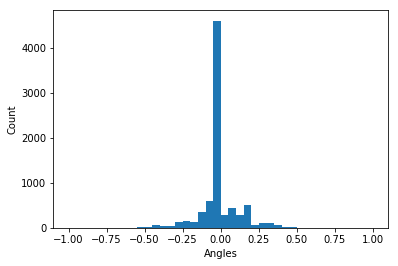

(3584, 7)


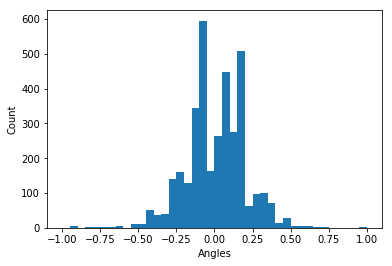

In [64]:
import os
import csv
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import cv2


samples = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for line in reader:
        samples.append(line)

print ("Number of training examples: ", len(samples))

s = np.array(samples)

angles = s[:,3]
angles = angles.astype(float)

bins = np.arange(-1, 1.01, 0.05) # fixed bin size

threshold = 1/90

print ("number of training examples with almost zero angles: ", ((-threshold < angles) & (angles < threshold)).sum())

plt.hist(angles, bins)
plt.xlabel('Angles')
plt.ylabel('Count')
plt.show()


samples = [x for x in samples if not (-threshold < float(x[3]) < threshold)]
print (np.array(samples).shape)

angles = np.array(samples)[:,3]
angles = angles.astype(float)

plt.hist(angles, bins)
plt.xlabel('Angles')
plt.ylabel('Count')
plt.show()

In [65]:
import math

def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def trans_image(image,steer,trans_range):
    # Translation
    image_tr = np.array(image)
    tr_x = trans_range*(np.random.uniform()-0.5)
    steer_ang = steer + tr_x/trans_range*2*.25
    tr_y = 40*np.random.uniform()-40/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image_tr,Trans_M,(image.shape[1], image.shape[0]))   
    return image_tr,steer_ang

def add_random_shadow(image):
    top_y = 320*np.random.uniform()
    top_x = 0
    bot_x = 160
    bot_y = 320*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    #random_bright = .25+.7*np.random.uniform()
    if np.random.randint(2)==1:
        random_bright = .9
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright    
    image = cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)
    return image

(3584, 2)


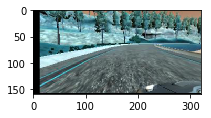

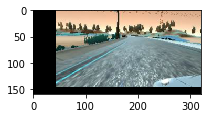

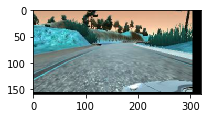

In [66]:
import random
import cv2

X = np.array(samples)[:,[1,3]]
print (X.shape)
    
for i in range(3):
    index = random.randint(0, X.shape[0])
    name = './data/IMG/'+X[index][0].split('/')[-1]
    center_image = cv2.imread(name)
    #fig = plt.figure(figsize=(3,3))
    #plt.imshow(center_image)
    #plt.imshow(add_random_shadow(center_image))
    #center_image = cv2.resize(center_image,(200,100), interpolation=cv2.INTER_AREA)
    #fig = plt.figure(figsize=(3,3))
    #plt.imshow(center_image[33:99][:])
    #fig = plt.figure(figsize=(3,3))
    #plt.imshow(center_image)
    #plt.imshow(augment_brightness_camera_images(center_image[60:140, 0:320]))
    tr_image, steer = trans_image(center_image, float(X[index][1]), 100)
    fig = plt.figure(figsize=(3,3))
    plt.imshow(tr_image)
plt.show()

In [67]:
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.1)

In [68]:
from sklearn.utils import shuffle

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:             
                angle = float(batch_sample[3])
                
                # create adjusted steering measurements for the side camera images
                correction = 0.07 # this is a parameter to tune
                
                which_image = np.random.randint(3)
                if which_image == 0:
                    name = './data/IMG/'+batch_sample[0].split('/')[-1]
                elif which_image == 1:
                    name = './data/IMG/'+batch_sample[1].split('/')[-1]
                    angle += correction
                else:
                    name = './data/IMG/'+batch_sample[2].split('/')[-1]
                    angle -= correction
                

                chosen_image = cv2.imread(name)
                if (chosen_image is None):
                    print (name)

                chosen_image = add_random_shadow(chosen_image)
                
                chosen_image = cv2.resize(chosen_image,(200,100), interpolation=cv2.INTER_AREA)
                
                chosen_image = augment_brightness_camera_images(chosen_image)
                
                chosen_image = cv2.cvtColor(chosen_image, cv2.COLOR_RGB2YCR_CB)        
                
                chosen_image, angle =  trans_image(chosen_image, angle, 50)
                
                if np.random.randint(2) == 0:
                    chosen_image = np.fliplr(chosen_image)
                    angle = -angle
                
                images.append(chosen_image)
                angles.append(angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            #print (X_train.shape, y_train.shape)
            yield sklearn.utils.shuffle(X_train, y_train)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

number_train_samples = int(len(samples)*.9)
samples_per_epoch = number_train_samples - (number_train_samples%(32*1))

In [69]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda, Cropping2D
from keras.layers import Convolution2D, MaxPooling2D


model = Sequential()

model.add(Cropping2D(cropping=((33,1), (0,0)), input_shape=(100,200,3)))
model.add(Lambda(lambda x: x/255 - 0.5))
model.add(Convolution2D(24,5,5,border_mode='valid', activation='relu', subsample=(2,2)))# -> (38,158,24)
#model.add(Dropout(0.50))
model.add(Convolution2D(36,5,5,border_mode='valid', activation='relu', subsample=(2,2)))# -> (17,77,36 )
#model.add(Dropout(0.50))
model.add(Convolution2D(48,5,5,border_mode='valid', activation='relu', subsample=(2,2)))# -> (7, 37, 48)
#model.add(Dropout(0.50))
model.add(Convolution2D(64,3,3,border_mode='valid', activation='relu', subsample=(1,1)))# -> (5, 35, 64)
#model.add(Dropout(0.50))
model.add(Convolution2D(64,3,3,border_mode='valid', activation='relu', subsample=(1,1)))# -> (3, 33, 64)
#model.add(Dropout(0.50))
model.add(Flatten())
model.add(Dense(1164, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='tanh'))

model.compile(loss='mse', optimizer='adam')

history_object = model.fit_generator(train_generator, samples_per_epoch =
    samples_per_epoch, validation_data = 
    validation_generator,
    nb_val_samples = samples_per_epoch,
    nb_epoch=10, verbose=1)

model.save('model.h5')

Epoch 1/10
3200/3200 [==============================] - 85s - loss: 0.0384 - val_loss: 0.0278

/Users/fengfengtu/anaconda/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1574: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


3225/3200 [==============================] - 89s - loss: 0.0250 - val_loss: 0.0284
Epoch 3/10
3225/3200 [==============================] - 90s - loss: 0.0225 - val_loss: 0.0240

dict_keys(['val_loss', 'loss'])


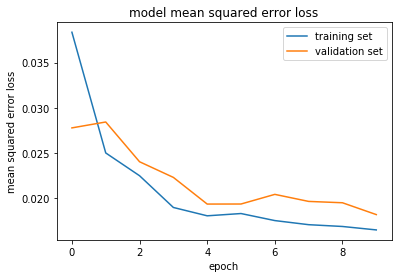

In [70]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [71]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_17 (Cropping2D)       (None, 66, 200, 3)    0           cropping2d_input_17[0][0]        
____________________________________________________________________________________________________
lambda_17 (Lambda)               (None, 66, 200, 3)    0           cropping2d_17[0][0]              
____________________________________________________________________________________________________
convolution2d_81 (Convolution2D) (None, 31, 98, 24)    1824        lambda_17[0][0]                  
____________________________________________________________________________________________________
convolution2d_82 (Convolution2D) (None, 14, 47, 36)    21636       convolution2d_81[0][0]           
___________________________________________________________________________________________